## Load libraries

In [2]:
import pandas as pd
import psycopg2

## Connect to the database

In [3]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Read data

In [11]:
benchmarkDataQuery = """
    select
    mor.micro_specimen_id
    , mor.person_id
    , case when (mor.seven_day_mortality = True) then 1 else 0 end as seven_day_mortality
    , case when (mor.fourteen_day_mortality = True) then 1 else 0 end as fourteen_day_mortality
    , case when (mor.twentyone_day_mortality = True) then 1 else 0 end as twentyone_day_mortality
    , case when (mor.twentyeight_day_mortality = True) then 1 else 0 end as twentyeight_day_mortality
    , case when (mor.sixty_day_mortality = True) then 1 else 0 end as sixty_day_mortality
    , case when (mor.ninety_day_mortality = True) then 1 else 0 end as ninety_day_mortality
    , case when (mor.onetwenty_day_mortality = True) then 1 else 0 end as onetwenty_day_mortality
    , sap.sapsii
    , sap.sapsii_prob
    from
    sepsis_micro.mortality mor
    inner join sepsis_micro.cohort coh
    on mor.micro_specimen_id = coh.micro_specimen_id
    inner join omop_cdm.person per
    on per.person_id = coh.person_id
    inner join mimiciv.patients pat
    on pat.subject_id = per.person_source_value::int
    inner join mimiciv.icustays icu
    on icu.subject_id = pat.subject_id and (coh.chart_time > (icu.intime - interval '2' day)) and (coh.chart_time < (icu.outtime + interval '2' day))
    inner join saps_ii.SAPSII sap
    on sap.stay_id = icu.stay_id
    ;
"""
benchmarkDataDf = pd.read_sql_query(benchmarkDataQuery, con)
benchmarkDataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,sapsii,sapsii_prob
0,4434759,892204370,0,0,0,0,1,1,1,21,0.041754
1,4926039,1192062955,0,0,0,0,0,0,0,17,0.025876
2,5302944,-2086157124,0,0,0,0,0,0,0,38,0.212560
3,1203417,1574178987,0,0,0,0,0,0,0,28,0.087706
4,7557189,1574178987,0,0,0,0,0,0,0,28,0.087706
...,...,...,...,...,...,...,...,...,...,...,...
10053,1966097,-1902202317,0,0,0,0,0,0,0,22,0.046739
10054,3768944,-548840452,0,1,1,1,1,1,1,45,0.347723
10055,6605625,727098078,0,0,0,0,0,0,0,17,0.025876
10056,6729116,727098078,0,0,0,0,0,0,0,17,0.025876


## ROC curve

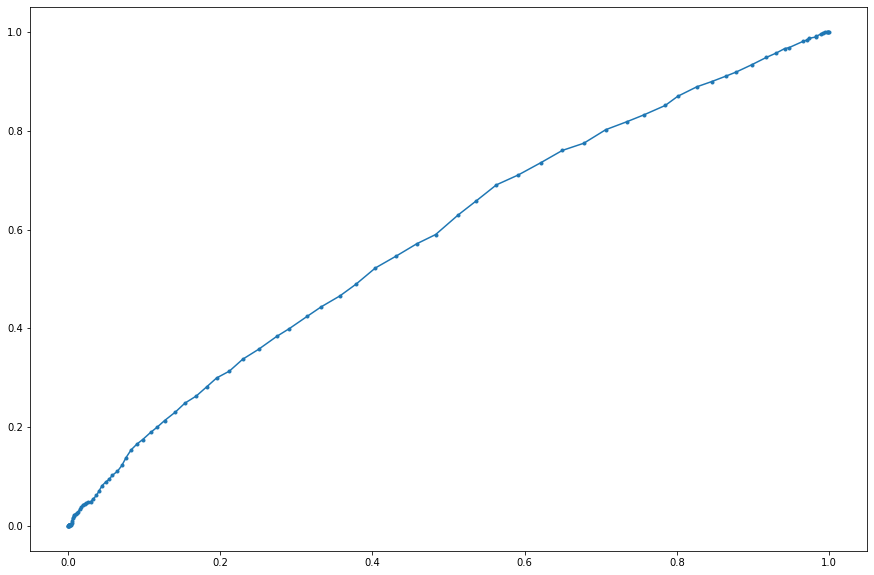

In [12]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.figure(figsize=(15,10))

fpr, tpr, _ = roc_curve(benchmarkDataDf.seven_day_mortality, dataDf.sapsii_prob)
plt.plot(fpr, tpr, marker='.', label='SAPS II')